# GMAC Pitch: Grid search of GMAC parameters

The pitch estimation for the GMAC algorithm has the following parameters:
1. Moving average window size for pitch estimation. $\left( n_{p} \right)$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [3]:
import seaborn as sns

### Custom Modules

In [4]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [5]:
import gmac

In [217]:
# Define the font family and size
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica']}

# # Set the font properties for various elements
# plt.rc('font', **font)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight


## Define notebook level constants

In [6]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [7]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

#### Parameter ranges for the grid search

In [155]:
basedir = "../data/output-new"
limbkey = "unaff"

# Make directory if it does not exist
outdir = pathlib.Path(basedir, limbkey, "pitch")
outdir.mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
pitch_param_ranges = {
    "np": list(map(int, [1, Fs // 2, Fs, 2*Fs, 4*Fs, 8*Fs])),
}

# Number of all possible combinations
Ncombs = len(pitch_param_ranges["np"])

In [156]:
# Which limb?
limbdf = datadf[limbkey]
subjects = limbdf.subject.unique()

# Estimate pitch for each subject.
accl_cols = ['ax', 'ay', 'az']
dfcols = ["subject"] + [f"np{int(_np)}" for _np in pitch_param_ranges["np"]] + ["pitch"]
pitch_df = pd.DataFrame(columns=dfcols)

for subj in subjects:
    # Go through all parameter combinations.
    _sinx = limbdf.subject == subj
    subj_pitch = np.zeros((len(limbdf[_sinx]), Ncombs))
    for _npinx, _np in enumerate(pitch_param_ranges["np"]):
        sys.stdout.write(f"\rEstimating pitch for subject {subj} {int(_np)}")
        sys.stdout.flush()
        # All segments
        segs = limbdf[_sinx].segment.unique()
        _pitch = [gmac.estimate_pitch(
                    accl=limbdf.loc[_sinx & (limbdf.segment == _seg), accl_cols].values,
                    farm_inx=0,
                    nwin=int(_np))
                  for _seg in segs]
        # Add column to subject pitch data
        subj_pitch[:, _npinx] = np.hstack(_pitch)
    # Add the groundtruth from IMU and subj name
    subj_pitch = np.hstack((subj * np.ones((subj_pitch.shape[0], 1)),
                            subj_pitch,
                            limbdf[_sinx].pitch.values.reshape(-1, 1)))
    # Add to dataframe
    pitch_df = pd.concat((pitch_df, pd.DataFrame(subj_pitch, columns=dfcols)),
                         ignore_index=True)    

# Save data
pitch_df.to_csv(pathlib.Path(outdir, "pitch.csv"), index=False)

Estimating pitch for subject 5 400

## Choosing the best filter parameter for pitch estimation

In [157]:
limb_types = ['left', 'right']

# Read data
pitch_df = {
    lmb: pd.read_csv(pathlib.Path(basedir, lmb, "pitch", "pitch.csv"))
    for lmb in ['left', 'right', 'aff', 'unaff']
}

In [251]:
# # Compute performance of pitch estimation
_limbdf = pd.DataFrame(columns=["subject", "np", "err", "corr", "limb"])
for _lmb in ["left", "right", "aff", "unaff"]:
    _df = pitch_df[_lmb]
    for i, _subj in enumerate(_df.subject.unique()):
        _sinx = _df.subject == _subj
        _gt = _df.loc[_df.subject == _subj, "pitch"].values
        for j, _np in enumerate(pitch_param_ranges["np"]):
            # Compute the 95th percentile absolute error
            _err = np.percentile(np.abs(_df.loc[_sinx, f"np{_np}"].values - _gt), 95)
            # Correlation coefficient
            _corr = scipy.stats.pearsonr(_df.loc[_sinx, f"np{_np}"].values, _gt)[0]
            # Temporary df
            _tempdf = pd.DataFrame([[_subj, _np, _err, _corr, _lmb]], columns=_limbdf.columns)
            _limbdf = pd.concat((_limbdf, _tempdf), ignore_index=True)

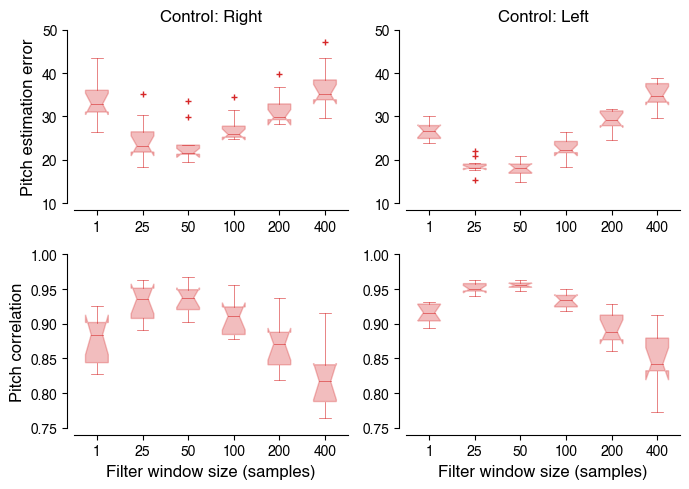

In [257]:
fig = plt.figure(figsize=(7, 5))

# RIGHT
# Pitch estimation error
ax = fig.add_subplot(221)
_linx = (_limbdf.limb == "right")
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["err"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_ylabel("Pitch estimation error", fontsize=12)
ax.set_title("Control: Right", fontsize=12)
ax.set_ylim((10, 50))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

ax = fig.add_subplot(222)
_linx = (_limbdf.limb == "left")
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["err"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_title("Control: Left", fontsize=12)
ax.set_ylim((10, 50))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))


# LEFT
_linx = (_limbdf.limb == "right")
# Pitch estimation error
ax = fig.add_subplot(223)
# Correlation coefficient
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["corr"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_xlabel("Filter window size (samples)", fontsize=12)
ax.set_ylabel("Pitch correlation", fontsize=12)
ax.set_ylim((0.75, 1.0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

# Correlation coefficient
_linx = (_limbdf.limb == "left")
ax = fig.add_subplot(224)
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["corr"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_xlabel("Filter window size (samples)", fontsize=12)
# ax.set_title("Pitch correlation", fontsize=12)
ax.set_ylim((0.75, 1.0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "pitch_perf_control.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "pitch_perf_control.svg"), bbox_inches="tight")

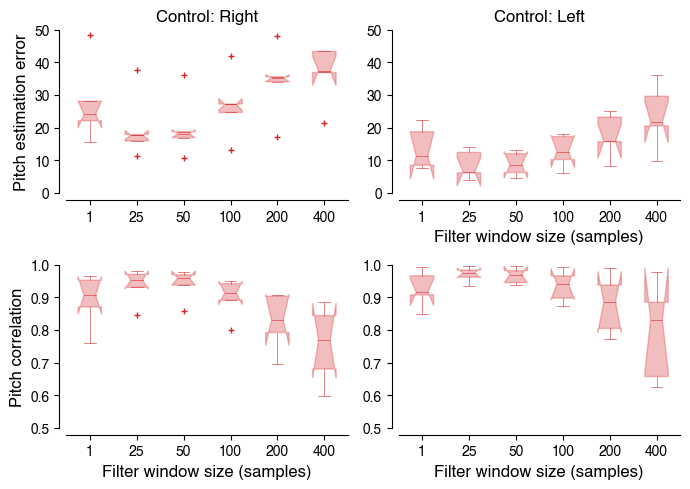

In [259]:
fig = plt.figure(figsize=(7, 5))

# RIGHT
# Pitch estimation error
ax = fig.add_subplot(221)
_linx = (_limbdf.limb == "unaff")
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["err"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_ylabel("Pitch estimation error", fontsize=12)
ax.set_title("Control: Right", fontsize=12)
ax.set_ylim((0, 50))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

ax = fig.add_subplot(222)
_linx = (_limbdf.limb == "aff")
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["err"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_xlabel("Filter window size (samples)", fontsize=12)
ax.set_title("Control: Left", fontsize=12)
ax.set_ylim((0, 50))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))


# LEFT
_linx = (_limbdf.limb == "unaff")
# Pitch estimation error
ax = fig.add_subplot(223)
# Correlation coefficient
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["corr"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_xlabel("Filter window size (samples)", fontsize=12)
ax.set_ylabel("Pitch correlation", fontsize=12)
ax.set_ylim((0.5, 1.0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

# Correlation coefficient
_linx = (_limbdf.limb == "aff")
ax = fig.add_subplot(224)
for i, _np in enumerate(pitch_param_ranges["np"]):
    ax.boxplot(x=_limbdf[_linx & (_limbdf.np == _np)]["corr"], positions=[i],
               widths=0.5, notch=True, patch_artist=True,
               boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
               capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
ax.set_xticklabels(pitch_param_ranges["np"], fontsize=12);
ax.set_xlabel("Filter window size (samples)", fontsize=12)
# ax.set_title("Pitch correlation", fontsize=12)
ax.set_ylim((0.5, 1.0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "pitch_perf_stroke.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "pitch_perf_stroke.svg"), bbox_inches="tight")

## Stats to analyse the effect of filter parameters

In [261]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [280]:
left_df = _limbdf[_limbdf.limb == "left"][["subject", "np", "err", "corr"]].reset_index(drop=True)
left_df["subject"] = left_df["subject"].astype(int)
left_df["np"] = left_df["np"].astype(int)
left_df["err"] = left_df["err"].astype(float)
left_df["corr"] = left_df["corr"].astype(float)
lme_left = smf.mixedlm("corr ~ np", data=left_df, groups=left_df["subject"])
lme_left.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: corr    
No. Observations: 60      Method:             REML    
No. Groups:       10      Scale:              0.0006  
Min. group size:  6       Log-Likelihood:     122.4874
Max. group size:  6       Converged:          Yes     
Mean group size:  6.0                                 
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   0.947    0.005 175.166 0.000  0.936  0.957
np         -0.000    0.000 -10.630 0.000 -0.000 -0.000
Group Var   0.000    0.005                            
======================================================

"""

In [282]:
right_df = _limbdf[_limbdf.limb == "right"][["subject", "np", "err", "corr"]].reset_index(drop=True)
right_df["subject"] = right_df["subject"].astype(int)
right_df["np"] = right_df["np"].astype(int)
right_df["err"] = right_df["err"].astype(float)
right_df["corr"] = right_df["corr"].astype(float)
lme_right = smf.mixedlm("corr ~ np", data=right_df, groups=right_df["subject"])
lme_right.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: corr    
No. Observations: 60      Method:             REML    
No. Groups:       10      Scale:              0.0008  
Min. group size:  6       Log-Likelihood:     105.7593
Max. group size:  6       Converged:          Yes     
Mean group size:  6.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.920    0.010 91.395 0.000  0.901  0.940
np          -0.000    0.000 -8.729 0.000 -0.000 -0.000
Group Var    0.001    0.016                           
======================================================

"""

In [283]:
aff_df = _limbdf[_limbdf.limb == "aff"][["subject", "np", "err", "corr"]].reset_index(drop=True)
aff_df["subject"] = aff_df["subject"].astype(int)
aff_df["np"] = aff_df["np"].astype(int)
aff_df["err"] = aff_df["err"].astype(float)
aff_df["corr"] = aff_df["corr"].astype(float)
lme_aff = smf.mixedlm("corr ~ np", data=aff_df, groups=aff_df["subject"])
lme_aff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: corr   
No. Observations: 30      Method:             REML   
No. Groups:       5       Scale:              0.0026 
Min. group size:  6       Log-Likelihood:     30.6978
Max. group size:  6       Converged:          Yes    
Mean group size:  6.0                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.965    0.030 32.388 0.000  0.906  1.023
np         -0.000    0.000 -6.076 0.000 -0.001 -0.000
Group Var   0.004    0.060                           
=====================================================

"""

In [285]:
unaff_df = _limbdf[_limbdf.limb == "unaff"][["subject", "np", "err", "corr"]].reset_index(drop=True)
unaff_df["subject"] = unaff_df["subject"].astype(int)
unaff_df["np"] = unaff_df["np"].astype(int)
unaff_df["err"] = unaff_df["err"].astype(float)
unaff_df["corr"] = unaff_df["corr"].astype(float)
lme_unaff = smf.mixedlm("corr ~ np", data=unaff_df, groups=unaff_df["subject"])
lme_unaff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: corr   
No. Observations: 30      Method:             REML   
No. Groups:       5       Scale:              0.0014 
Min. group size:  6       Log-Likelihood:     37.4563
Max. group size:  6       Converged:          Yes    
Mean group size:  6.0                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.932    0.034 27.502 0.000  0.865  0.998
np         -0.000    0.000 -8.882 0.000 -0.001 -0.000
Group Var   0.005    0.112                           
=====================================================

"""

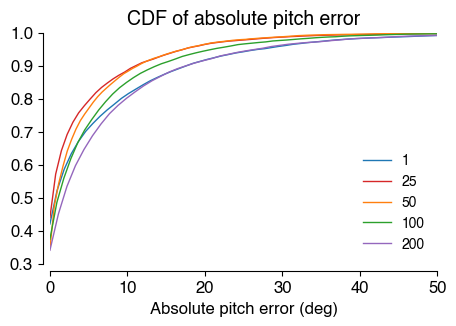

In [204]:
_subj = 2
_sinx = _df.subject == _subj
_gt = _df.loc[_df.subject == _subj, "pitch"].values
colors = ["tab:blue", "tab:red", "tab:orange", "tab:green", "tab:purple", "tab:brown"]
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
for i, _np in enumerate(pitch_param_ranges["np"][:-1]):
    p, x = np.histogram(np.abs(_df.loc[_sinx, f"np{_np}"].values - _gt), bins=100, density=True)
    ax.plot(x[:-1], np.cumsum(p) * np.diff(x)[0], lw=1, color=colors[i], label=f"{_np}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.set_xlabel("Absolute pitch error (deg)", fontsize=12)
ax.set_title("CDF of absolute pitch error", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 50)
ax.set_ylim(0.3, 1.0)
ax.legend(loc=4, frameon=False, fontsize=10)

